# On normalizing flows


- density estimation (i.e., moon data) and sampling
- (variational) inference and reparameterization for MCMC (see orig flow paper)

- autoregressive flows (transformer and conditioner)
- coupling flows (realnvp)
- masked autoregressive flows
- ffored
- inverse autoregressive flows
-planar and radial
 => easy to compute jacobian! 

- cubic spline flows

- references:
    - the one blog
    - review from papa
    - orig papers
    - eric jang

In [1]:
import pymc4

## Normalizing flows

explain theory here. change of variables, etc.

explain that lower jacobian is good

explain how multiple jacobians compuite

explain how jacobian is computed

In [1]:
## Density estimation, a simple example using TFP (data real nvp data)


## Variational inference
## Density estimation

make more complex examples with TFP

In [46]:
import tensorflow as tf
import tensorflow_probability as tfp

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import numpy as np
n = 2000
x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
data = np.stack([x1, x2], axis=-1)


In [ ]:
n = 1000

(-2.0, 2.0)

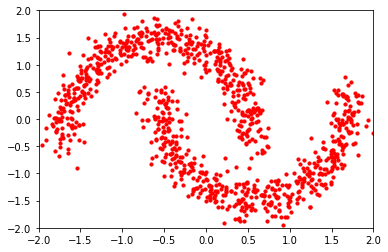

In [13]:
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.1)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)


xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

In [141]:
def make_degrees(p, hidden_dims):
    m = [tf.constant(range(1, p + 1))]
    for dim in hidden_dims:                
        n_min = min(np.min(m[-1]), p - 1)
        #degrees = np.random.randint(low=n_min, high=p, size=dim)
        degrees = (np.arange(dim) % max(1, p - 1) + min(1, p - 1))
        degrees = tf.constant(degrees, dtype="int32")
        m.append(degrees)
    return m

In [121]:
def make_masks(degrees):
    masks = [None] * len(degrees)
    for i, (ind, outd) in enumerate(zip(degrees[:-1], degrees[1:])):
        masks[i] = tf.cast(ind[:, tf.newaxis] <= outd, dtype="int32")        
    masks[-1] = tf.cast(degrees[-1][:, np.newaxis] < degrees[0], dtype="int32")
    return masks

In [185]:
def make_constraint(mask):    
    def _constraint(x):
        return mask * tf.identity(x)
    return _constraint

In [377]:
def make_init(mask):
    def _init(shape, dtype=None):
        return tf.cast(mask, "float32") * tf.keras.initializers.GlorotUniform()(shape)
    return _init

In [378]:
p = 2
params = 2
hidden_dims = [4, 4]

In [384]:
def make_network(p, hidden_dims, params):
    masks = make_masks(make_degrees(p, hidden_dims))    
    masks[-1] = tf.tile(masks[-1][..., tf.newaxis], [1, 1, params])
    masks[-1] = tf.reshape(masks[-1], [masks[-1].shape[0], p * params])
    
    network =  tf.keras.Sequential([
        tf.keras.layers.InputLayer((p,))
    ])
    for dim, mask in zip(hidden_dims + [p * params], masks):
        layer = tf.keras.layers.Dense(
            dim,
            kernel_constraint=make_masked_constraint(mask),
            kernel_initializer=make_init(mask),
            activation=tf.nn.leaky_relu)
        network.add(layer)    
    network.add(tf.keras.layers.Reshape([p, params]))
    
    return network

In [385]:
network = make_layers(2, [4], 2)

[<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[1, 1, 1, 1],
       [0, 0, 0, 0]], dtype=int32)>, <tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int32)>]
[<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[1, 1, 1, 1],
       [0, 0, 0, 0]], dtype=int32)>, <tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1]], dtype=int32)>]


In [381]:
network(data)

<tf.Tensor: shape=(5, 2, 2), dtype=float32, numpy=
array([[[ 0.        ,  0.        ],
        [-0.15768307, -0.01101868]],

       [[ 0.        ,  0.        ],
        [-0.23938635, -0.016728  ]],

       [[ 0.        ,  0.        ],
        [-0.12781058, -0.00893123]],

       [[ 0.        ,  0.        ],
        [ 0.05857328,  0.00509455]],

       [[ 0.        ,  0.        ],
        [ 0.0964986 ,  0.0083932 ]]], dtype=float32)>

In [306]:
network.trainable_variables

[<tf.Variable 'dense_105/kernel:0' shape=(2, 4) dtype=float32, numpy=
 array([[-0.27668595,  0.7513983 , -0.6500809 , -0.03027487],
        [-0.33908415,  0.17353892, -0.69187903, -0.47112536]],
       dtype=float32)>,
 <tf.Variable 'dense_105/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_106/kernel:0' shape=(4, 4) dtype=float32, numpy=
 array([[ 0.10907745,  0.02073228,  0.15648776,  0.3985247 ],
        [-0.09262514,  0.81670684, -0.07310176,  0.66671544],
        [ 0.720388  ,  0.4259991 ,  0.84626824, -0.56670934],
        [ 0.4458149 ,  0.7332917 , -0.57358754,  0.3560118 ]],
       dtype=float32)>,
 <tf.Variable 'dense_106/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_107/kernel:0' shape=(4, 4) dtype=float32, numpy=
 array([[ 0.04139775, -0.18996793, -0.58731306,  0.7198778 ],
        [-0.73172086, -0.57082653,  0.12134916,  0.08347064],
        [ 0.6305625 ,  0.0894995

In [307]:
n = 2000
x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
data = np.stack([x1, x2], axis=-1)

# Density estimation with MADE.
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[4, 4])

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.MaskedAutoregressiveFlow(made),
    event_shape=[2])


In [308]:
distribution.log_prob(data)

<tf.Tensor: shape=(2000,), dtype=float32, numpy=
array([-16.219797 , -12.8678465,  -2.499713 , ...,  -1.9765717,
       -16.736002 ,  -2.0409515], dtype=float32)>

In [310]:
bij = tfb.MaskedAutoregressiveFlow(made)


In [314]:
bij.trainable_variables

(<tf.Variable 'dense_108/kernel:0' shape=(2, 4) dtype=float32, numpy=
 array([[ 0.45917106, -0.5719979 ,  0.5357535 , -0.97801065],
        [-0.        , -0.        ,  0.        , -0.        ]],
       dtype=float32)>,
 <tf.Variable 'dense_108/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_109/kernel:0' shape=(4, 4) dtype=float32, numpy=
 array([[-0.10191208, -0.42034867, -0.02775025, -0.71254355],
        [-0.14687335,  0.5028265 , -0.07908547, -0.30305618],
        [ 0.5112799 , -0.5114329 ,  0.41874105,  0.7199697 ],
        [-0.69449437, -0.85607857, -0.4919989 ,  0.7287844 ]],
       dtype=float32)>,
 <tf.Variable 'dense_109/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_110/kernel:0' shape=(4, 4) dtype=float32, numpy=
 array([[-0.        , -0.        , -0.26757646, -0.608544  ],
        [ 0.        ,  0.        , -0.06213725, -0.07378978],
        [-0.        ,  0.       

In [81]:
def make_maf(p):
    net_init, net_apply = stax.serial(
        Dense(512), Relu, Dense(512), Relu, Dense(D))
    in_shape = (-1, p // 2)
    out_shape, net_params = net_init(rng, in_shape)
    
    def shift_and_log_scale_fn(net_params, x1):
        s = net_apply(net_params, x1)
        return np.split(s, 2, axis=1)
    
    return net_params, shift_and_log_scale_fn

In [7]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))

In [48]:
class LeakyReLU(tfb.Bijector):
    def __init__(self, alpha=0.5, validate_args=False, name="leaky_relu"):
        super(LeakyReLU, self).__init__(
            forward_min_event_ndims=1, validate_args=validate_args, name=name)
        self.alpha = alpha

    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)

    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1. / self.alpha * y)

    def _inverse_log_det_jacobian(self, y):

        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1.0 / self.alpha * I)
        # abs is actually redundant here, since this det Jacobian is > 0
        log_abs_det_J_inv = tf.math.log(tf.abs(J_inv))
        return tf.reduce_sum(log_abs_det_J_inv, axis=event_dims)

In [76]:
bi = tfb.Chain([tfb.Affine(shift=0, 
                           scale_identity_multiplier=1.),
           #
           tfb.Affine(scale_identity_multiplier=1.)])

In [77]:
bi.forward_log_det_jacobian(x, 1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [3]:
import jax.numpy as np
from jax import random

In [73]:
def sample_n01(N, D = 2):    
    return random.normal(rng, (N, D))

def log_prob_n01(x):
    return np.sum(-np.square(x)/2 - np.log(np.sqrt(2*np.pi)),axis=-1)

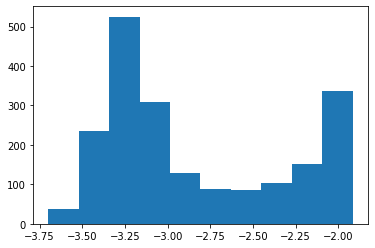

In [75]:
plt.hist(log_prob_n01(X));

In [319]:
from jax.experimental import stax
from jax import random
from jax.experimental.stax import Dense, Relu

In [320]:
rng = random.PRNGKey(0)

/home/simon/miniconda3/envs/pymc/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [4]:
import edward2 as ed
import numpy as np
import tensorflow as tf

In [91]:
np.random.seed(1328)
batch_size = 2
length = 3
channels = 5
units = 2
network = ed.layers.MADE(2, [4],
                         input_order='right-to-left',
                         activation=tf.nn.relu,
                         use_bias=False)
inputs = tf.zeros([50, length, 1])

In [92]:
s = network(inputs)

In [93]:
network.

[<tf.Variable 'dense_46/kernel:0' shape=(3, 4) dtype=float32, numpy=
 array([[ 0.        , -0.        , -0.        , -0.        ],
        [-0.        ,  0.68929636, -0.        ,  0.02778322],
        [-0.03103018,  0.91377187, -0.6366861 ,  0.827657  ]],
       dtype=float32)>,
 <tf.Variable 'dense_47/kernel:0' shape=(4, 6) dtype=float32, numpy=
 array([[ 0.6266922 , -0.45900744, -0.26853657,  0.5486729 , -0.        ,
         -0.        ],
        [-0.01287782,  0.01671875,  0.        ,  0.        , -0.        ,
          0.        ],
        [ 0.13144398, -0.36654124,  0.07519454, -0.5006738 ,  0.        ,
          0.        ],
        [ 0.1700257 , -0.67919946,  0.        , -0.        , -0.        ,
         -0.        ]], dtype=float32)>]

In [328]:
n = 5
x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
data = np.stack([x1, x2], axis=-1)

In [333]:
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[5], use_bias=False)

In [334]:
made(data)

<tf.Tensor: shape=(5, 2, 2), dtype=float32, numpy=
array([[[ 0.        ,  0.        ],
        [-0.8871505 ,  0.8813934 ]],

       [[ 0.        ,  0.        ],
        [-1.3468263 ,  1.338086  ]],

       [[ 0.        ,  0.        ],
        [-0.7190831 ,  0.71441656]],

       [[ 0.        ,  0.        ],
        [ 0.295628  , -0.2937095 ]],

       [[ 0.        ,  0.        ],
        [ 0.48704278, -0.48388213]]], dtype=float32)>

In [ ]:

# Density estimation with MADE.


distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.MaskedAutoregressiveFlow(made),
    event_shape=[2])

# Construct and fit model.
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob)

batch_size = 25
model.fit(x=data,
          y=np.zeros((n, 0), dtype=np.float32),
          batch_size=batch_size,
          epochs=1,
          steps_per_epoch=1,  # Usually `n // batch_size`.
          shuffle=True,
          verbose=True)

# Use the fitted distribution.
distribution.sample((3, 1))
distribution.log_prob(np.ones((3, 2), dtype=np.float32))
